Using a decision tree model to look at the decision path used to classify a student as being likely to score 10 or more. Choose the data\_file for either first term or final term.

Three "personas" are available:
- "me" is record 11 in the training dataset
- "middle-class" is a fictional good background, good behaviour student
- "wild-child" is a fictional student with a less supportive background and going-out habits.

In [1]:
data_file = r'Student_Prepared_FirstTerm.csv'  # Student_Prepared_FirstTerm.csv or Student_Prepared_FinalTerm.csv
# CHOOSE A PERSONA: "me", "wild-child", "middle-class"
persona = "middle-class"  # "me", "middle-class"

In [2]:
%run "Prep Student Classifier.ipynb"

In [3]:
import numpy as np
import pydotplus
from IPython.display import Image

In [4]:
# The decision clf has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

## Decision Path
This shows the sequence of attributes (and how their value compared against the threshold in the decision tree) used to classify a student as being likely to gain a mark of 10 or more. Note that the attributes which are important in making the prediction may differ from those which are important overall in the model.

In [5]:
# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.
X_test = prep_vector_for_classifier(personas[persona])
node_indicator = clf.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.
leave_id = clf.apply(X_test)

In [6]:
# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.

sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used (in order) to predict persona %s: ' % persona)
for node_id in node_index:
    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = "<="
    else:
        threshold_sign = ">"

    print("decision id node %s : (X_test[%s, %s] (= %s) %s %s)"
          % (node_id,
             sample_id,
             dummied_data_cols[feature[node_id]],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))


Rules used (in order) to predict persona middle-class: 
decision id node 0 : (X_test[0, failures] (= 0.0) <= 0.5)
decision id node 1 : (X_test[0, higher_no] (= 0.0) <= 0.5)
decision id node 2 : (X_test[0, Subject_Portuguese] (= 0.0) <= 0.5)
decision id node 3 : (X_test[0, Fedu_1] (= 1.0) > 0.5)
decision id node 7 : (X_test[0, studytime_2] (= 0.0) <= 0.5)
decision id node 8 : (X_test[0, romantic_no] (= 1.0) > -2.0)


## Tree Structure
Not practicable for random forest.

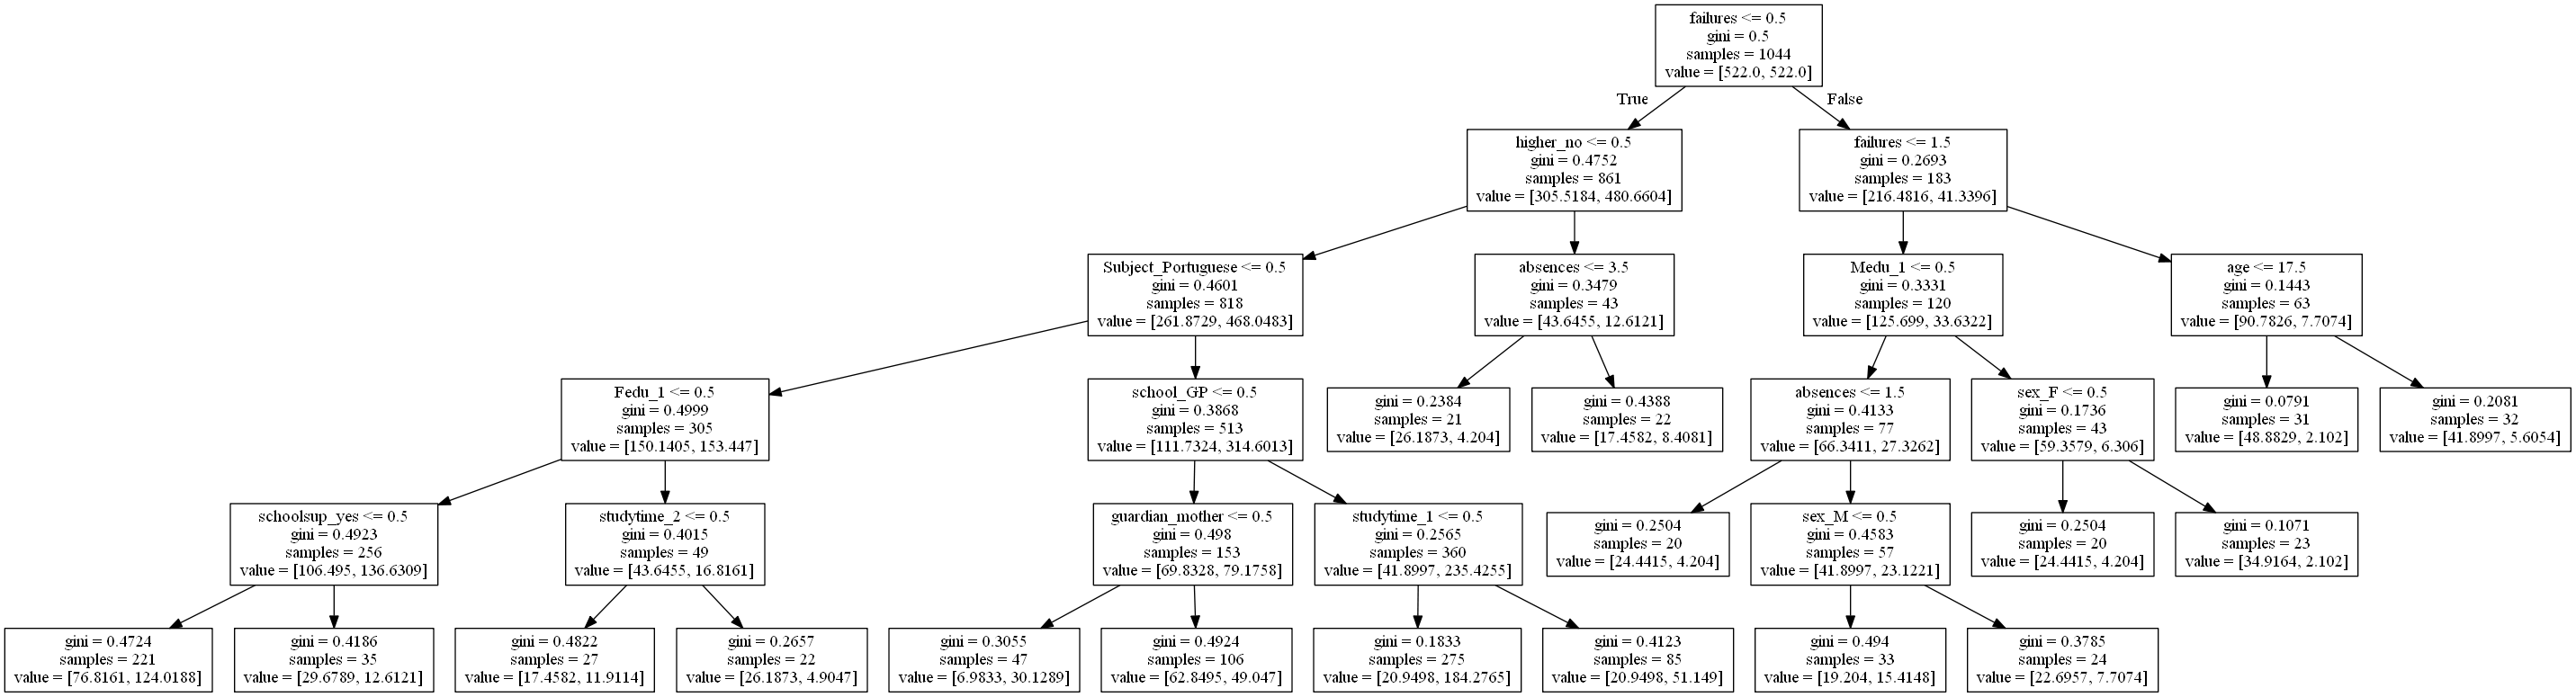

In [7]:
#save the tree to a ".dot" file for viewing. I couldn't get in-notebook image creatio to work
tree_file = "student_tree OUT"
with open(tree_file+'.dot', 'w') as f:
    tree.export_graphviz(clf, out_file=f,  
                         feature_names=dummied_data_cols)#,  
                         #class_names=["Retained","Withdrew"],  #not in vsn on predlin
                         #filled=True, rounded=True,  
                         #special_characters=True)  

dot_graph = pydotplus.graph_from_dot_file(tree_file+'.dot')
dot_graph.write_pdf(tree_file+'.pdf')
dot_graph.write_png(tree_file+'.png');

Image(tree_file+'.png')